In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math

In [3]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
file_directory = '/content/drive/MyDrive/momentum-strategies/technical_indicators'

In [506]:
spy_df = pd.read_csv(f'{file_directory}/SPY_daily161118_211117.csv')

In [4]:
qqq_df = pd.read_csv(f'{file_directory}/QQQ_daily161118_211117.csv')

In [5]:
tqqq_df = pd.read_csv(f'{file_directory}/TQQQ_daily161118_211117.csv')

In [427]:
class Portfolio:
  def __init__(self, benchmark_df, benchmark_name, to_csv, fee_rate=0.0025, tax_rate=0.22, tax_threshold=2500000 / 1100):
    self.df = benchmark_df.copy()
    self.df.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
    self.benchmark_closes = benchmark_df['Close'].to_numpy()
    self.benchmark_opens = benchmark_df['Open'].to_numpy()
    self.benchmark_highs = benchmark_df['High'].to_numpy()
    self.benchmark_lows = benchmark_df['Low'].to_numpy()
    self.benchmark_name = benchmark_name
    self.to_csv = to_csv
    self.fee_rate = fee_rate
    self.tax_rate = tax_rate
    self.tax_threshold = tax_threshold
  
  def init_config(self, initial_cash=10000):
    self.df_columns = [
      'rsi', 'entry_signal', 'exit_signal', 'entry_price', 'exit_price', 
      'in_position', 'shares', 'position_size', 'cash', 
      'fee', 'tax', 'annual_gain',
    ]
    for column in self.df_columns:
      setattr(self, column, np.zeros(len(self.benchmark_closes)))
    self.cash[0] = initial_cash

  def buy_and_hold(self, start):
    self.name = self.benchmark_name + "_bnh"
    self.cash[:start + 1] = self.cash[0]
    shares_delta = self.cash[start] // self.benchmark_opens[start]
    self.cash[start:] = self.cash[0] - shares_delta * self.benchmark_opens[start]
    self.shares[start:] = shares_delta
    self.entry_price[start:] = self.benchmark_opens[start]
    self.save_to_df()
    return self.df['portfolio_closes']

  def get_rsi(self, window_length):
    self.window_length = window_length
    # Calculate the RSI based on MMA
    delta = self.df['Close'].diff()
    # first row is NaN since it did not have a previous row to calculate the differences
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()
    # Make the positive gains (up) and negative gains (down) Series
    alpha = 1 / window_length
    roll_up = up.ewm(alpha=alpha).mean()
    roll_down = down.ewm(alpha=alpha).mean()
    rs = roll_up / roll_down
    rsi_mma = 100.0 - (100.0 / (1.0 + rs))
    self.rsi = rsi_mma.to_numpy()

  def set_entry_signal(self, entry_threshold, entry_mode):
    self.entry_threshold = entry_threshold
    self.entry_mode = entry_mode
    if entry_mode == 'up':
      self.entry_signal[self.rsi > entry_threshold] = 1
    elif entry_mode == 'down':
      self.entry_signal[self.rsi < entry_threshold] = 1
  
  def set_exit_signal(self, exit_threshold, exit_mode):
    self.exit_threshold = exit_threshold
    self.exit_mode = exit_mode
    if exit_mode == 'up':
      self.exit_signal[self.rsi > exit_threshold] = 1
    elif exit_mode == 'down':
      self.exit_signal[self.rsi < exit_threshold] = 1
    
  def entry(self, i, entry_shares):
    self.in_position[i] = 1
    self.entry_price[i] = self.benchmark_opens[i]
    self.shares[i] += entry_shares
    entry_amount = entry_shares * self.entry_price[i]
    self.cash[i] -= entry_amount * (1 + self.fee_rate)
    self.fee[i] = entry_amount * self.fee_rate

  def exit(self, i, exit_shares):
    self.in_position[i] = 0
    self.exit_price[i] = self.benchmark_opens[i]
    self.shares[i] -= exit_shares
    exit_amount = exit_shares * self.exit_price[i]
    self.cash[i] += exit_amount * (1 - self.fee_rate)
    self.fee[i] = exit_amount * self.fee_rate

  def backtest(self, window_length=14, entry_threshold=(50, 'up'), exit_threshold=(50,'down')):
    self.get_rsi(window_length)
    self.set_entry_signal(*entry_threshold)
    self.set_exit_signal(*exit_threshold)
    self.name = f'rsi{self.window_length}_{self.entry_threshold}{self.entry_mode}:{self.exit_threshold}{self.exit_mode}'
    for i in range(1, len(self.benchmark_closes)):
      self.in_position[i] = self.in_position[i - 1]
      self.cash[i] = self.cash[i - 1]
      self.shares[i] = self.shares[i - 1]
      if self.exit_signal[i - 1] > 0:
        if self.in_position[i] > 0:
          self.exit(i, self.shares[i])
      if self.entry_signal[i - 1] > 0:
        if self.in_position[i - 1] == 0:
          shares_plus = self.cash[i] / (1 + self.fee_rate) // self.benchmark_opens[i]
          self.entry(i, shares_plus)
    self.save_to_df()
    return self.df['portfolio_closes']
          
  def trading_statistics(self):
    entry = self.entry_price[self.entry_price > 0]
    exit = self.exit_price[self.exit_price > 0]
    min_size = min(entry.size, exit.size)
    self.trade_return = (exit[:min_size] - entry[:min_size]) / entry[:min_size]
    print((self.trade_return * 100))
    self.performance = np.prod(self.trade_return + 1)
    return self.performance

  def save_to_df(self):
    for column in self.df_columns:
      self.df[column] = getattr(self, column)
    self.df['portfolio_closes'] = self.cash + self.shares * self.benchmark_closes
    if self.to_csv:
      self.df.to_csv(f'{file_directory}/{current_date}_{self.benchmark_name}_{self.name}.csv')

In [403]:
portfolio = Portfolio(qqq_df, 'qqq')
portfolio.init_config()
portfolio.backtest(window_length=14, entry_threshold=(40, 'down'), exit_threshold=(80, 'up'))
portfolio.save_to_df(to_csv=True)

In [402]:
portfolio.trading_statistics()

[ 9.34786574  7.35463039 20.44854298 16.80259571 15.57398439 33.5274383 ]


2.548682517436545

In [428]:
def get_performance_df(benchmark_df, benchmark_name, initial_cash, backtest_details, bnh_start=0, to_csv=False):
  performance_df = pd.DataFrame({'date': benchmark_df['Date']})
  portfolio = Portfolio(benchmark_df, benchmark_name, to_csv)
  portfolio.init_config(initial_cash=initial_cash)
  performance_df[portfolio.name] = portfolio.buy_and_hold(start=bnh_start)
  for detail in backtest_details:
    portfolio.init_config(initial_cash=initial_cash)
    performance_df[portfolio.name] = portfolio.backtest(**detail)
  performance_df.to_csv(f'{file_directory}/{current_date}_performance.csv')
  return performance_df

In [420]:
def chart(performance_df, y_min, y_max, y_step, title):
  chart = performance_df.plot(x='date', grid=True, figsize=(40,25), xticks=np.arange(0, len(performance_df['date']), 20), yticks=np.arange(y_min, y_max, y_step), title=title)
  chart.tick_params(axis='x', rotation=90)
  chart.figure.savefig(f'{file_directory}/{current_date}_performance.jpg')
  # chart.set_yscale('log')
  return chart

In [500]:
backtest_details = [
  {'window_length':14, 'entry_threshold':(50, 'up'), 'exit_threshold':(40, 'down')},
  {'window_length':14, 'entry_threshold':(60, 'up'), 'exit_threshold':(40, 'down')},
  {'window_length':14, 'entry_threshold':(70, 'up'), 'exit_threshold':(40, 'down')},
]
performance_df = get_performance_df(qqq_df, 'qqq', 10000, backtest_details, bnh_start=0, to_csv=False)

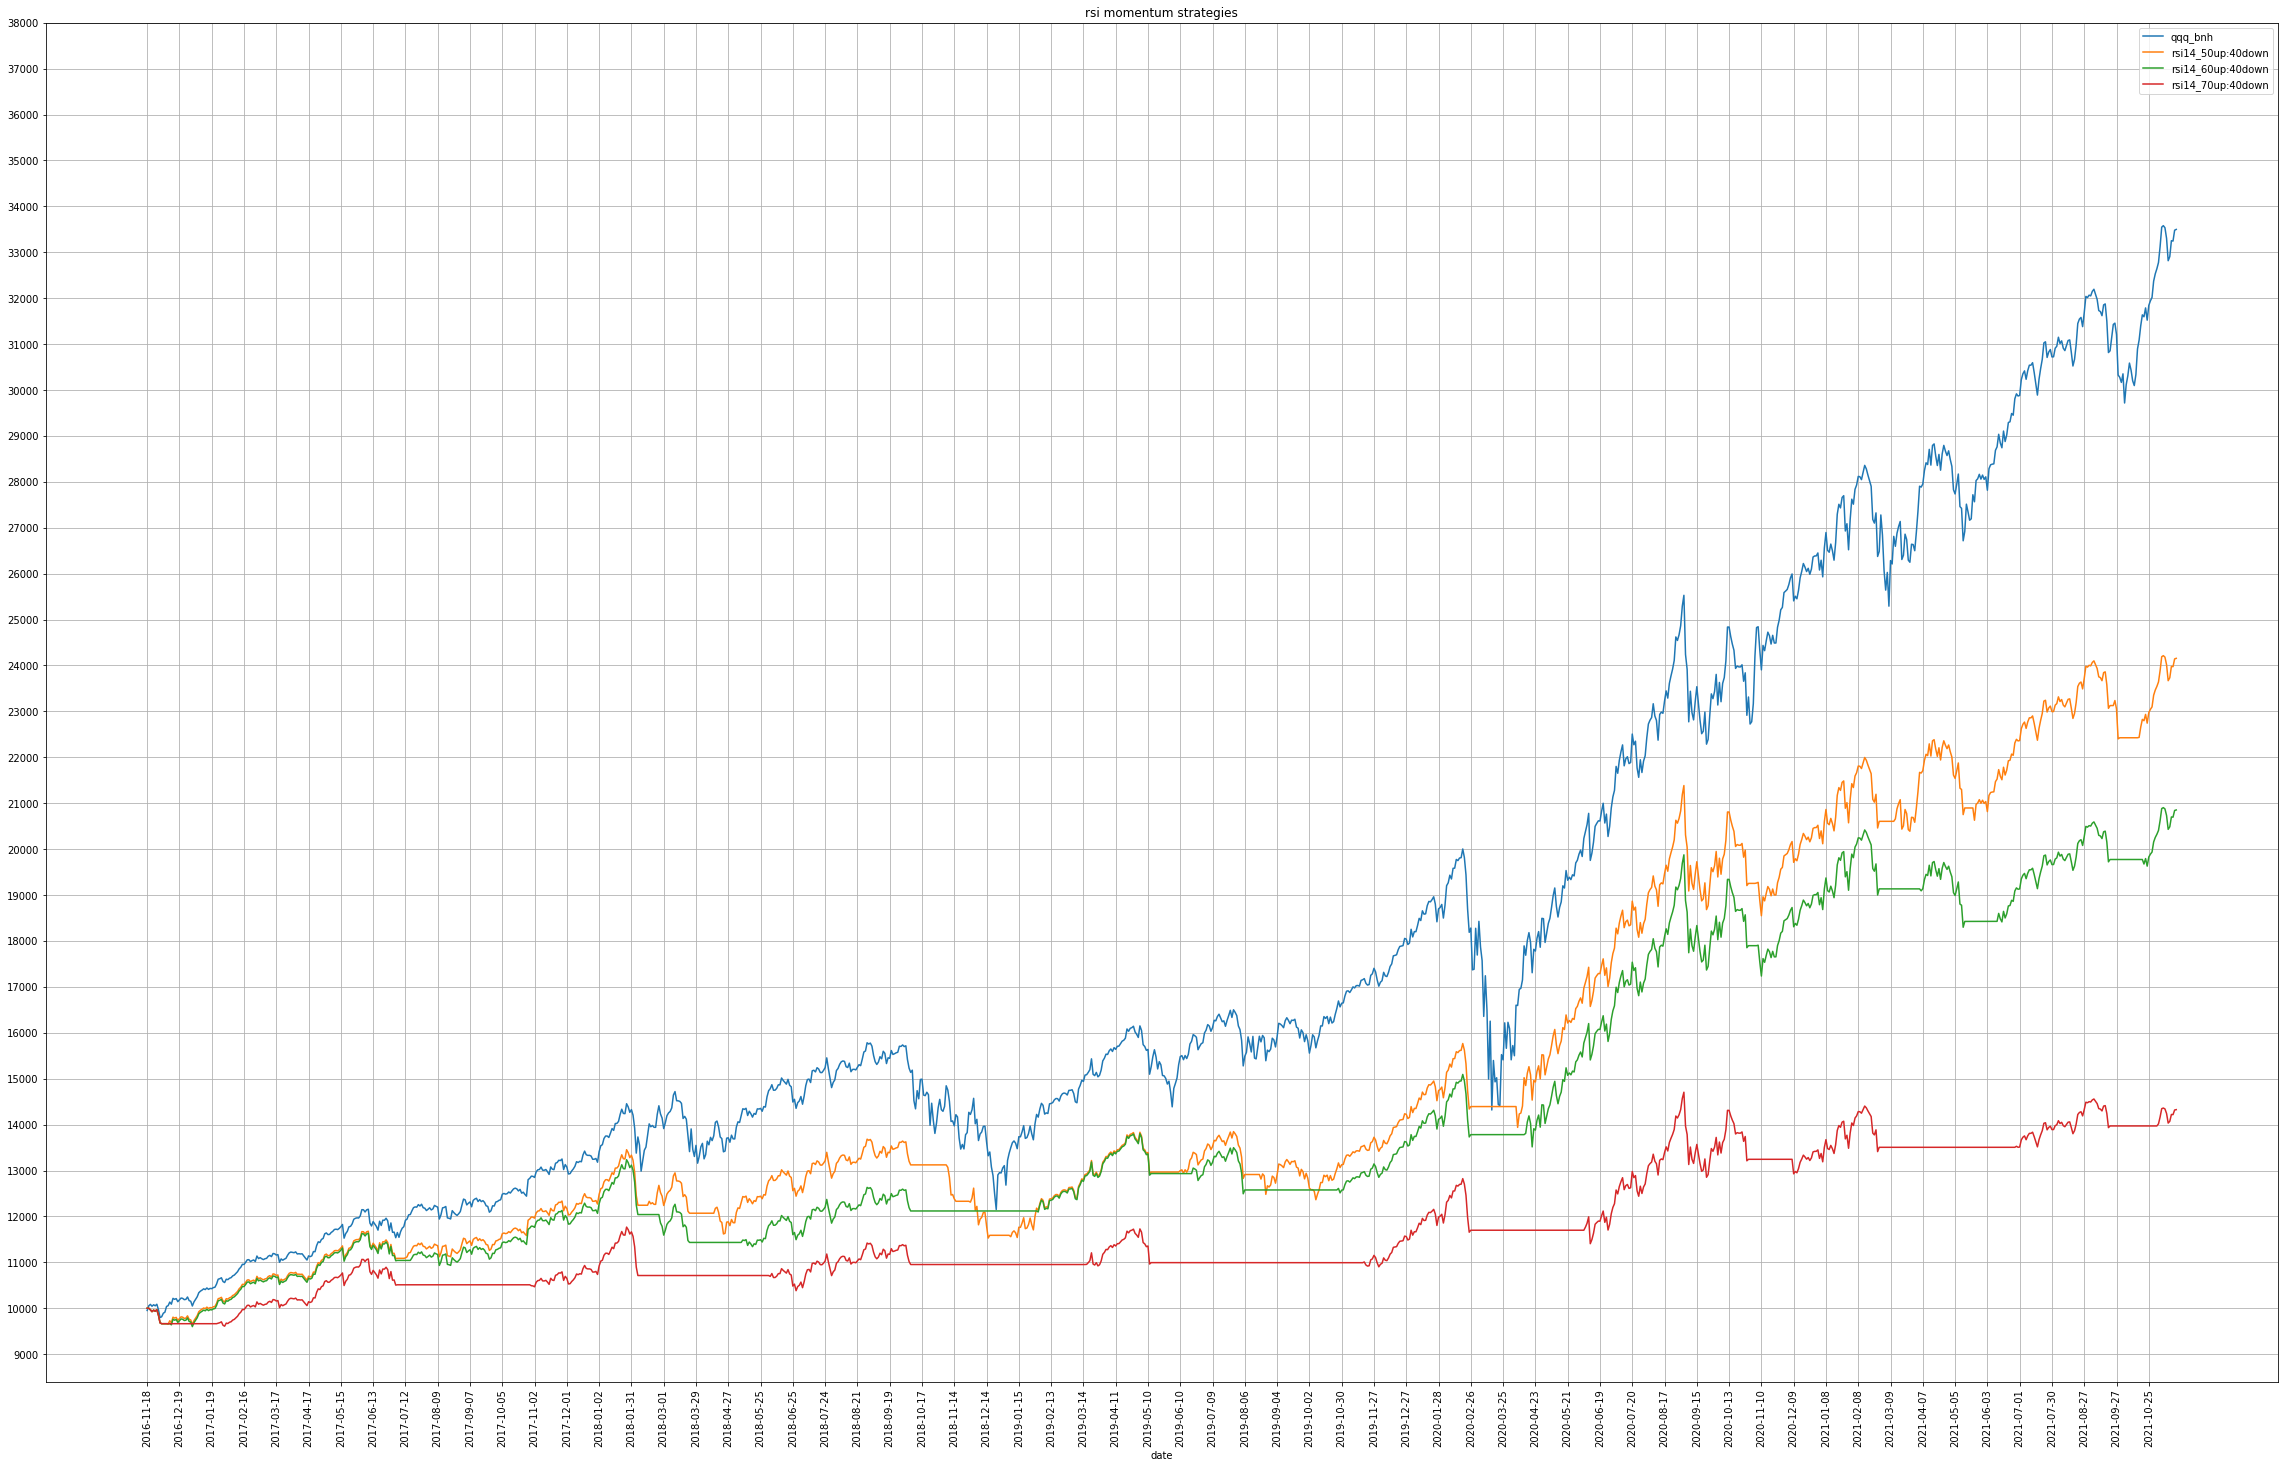

In [501]:
chart(performance_df, 9000, 39000, 1000, 'rsi momentum strategies')

In [502]:
backtest_details = [
  {'window_length':14, 'entry_threshold':(30, 'down'), 'exit_threshold':(70, 'up')},
  {'window_length':14, 'entry_threshold':(40, 'down'), 'exit_threshold':(70, 'up')},
  {'window_length':14, 'entry_threshold':(50, 'down'), 'exit_threshold':(70, 'up')},
  {'window_length':14, 'entry_threshold':(60, 'down'), 'exit_threshold':(70, 'up')},
  {'window_length':14, 'entry_threshold':(30, 'down'), 'exit_threshold':(80, 'up')},
  {'window_length':14, 'entry_threshold':(40, 'down'), 'exit_threshold':(80, 'up')},
  {'window_length':14, 'entry_threshold':(50, 'down'), 'exit_threshold':(80, 'up')},
  {'window_length':14, 'entry_threshold':(60, 'down'), 'exit_threshold':(80, 'up')},
]
performance_df = get_performance_df(qqq_df, 'qqq', 10000, backtest_details, bnh_start=0, to_csv=False)

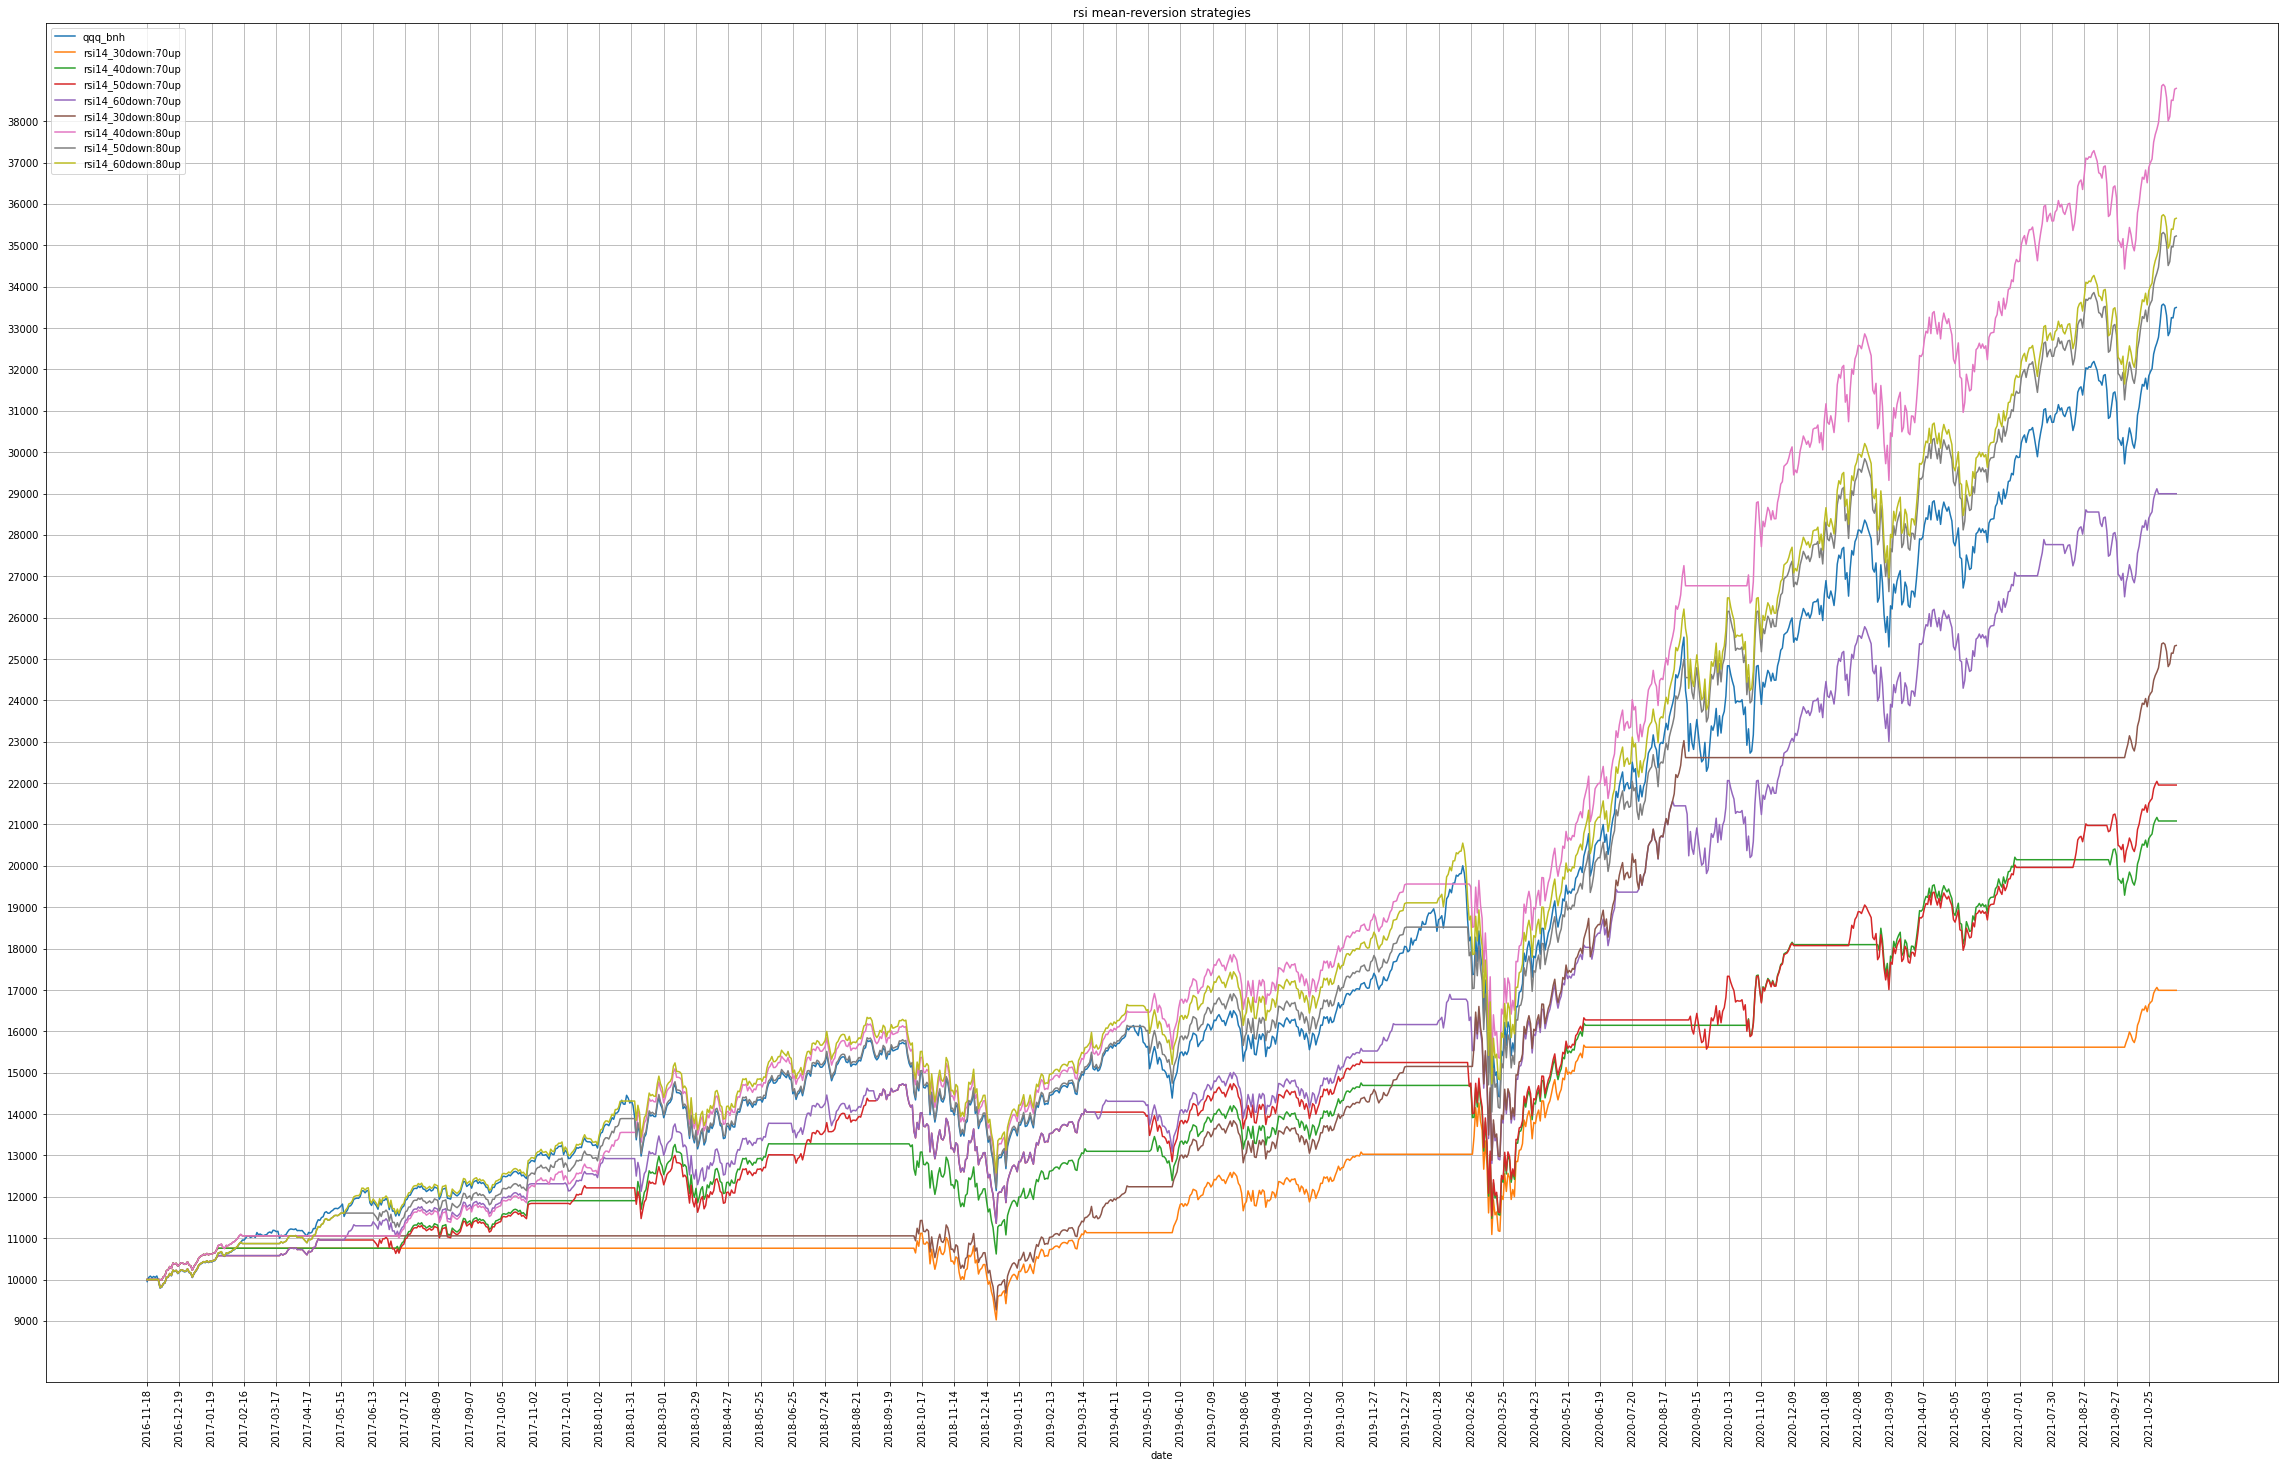

In [503]:
chart(performance_df, 9000, 39000, 1000, 'rsi mean-reversion strategies')

In [511]:
backtest_details = [
  {'window_length':14, 'entry_threshold':(50, 'up'), 'exit_threshold':(40, 'down')},
  {'window_length':14, 'entry_threshold':(60, 'up'), 'exit_threshold':(40, 'down')},
  {'window_length':14, 'entry_threshold':(70, 'up'), 'exit_threshold':(40, 'down')},
]
performance_df = get_performance_df(spy_df, 'spy', 10000, backtest_details, bnh_start=0, to_csv=False)

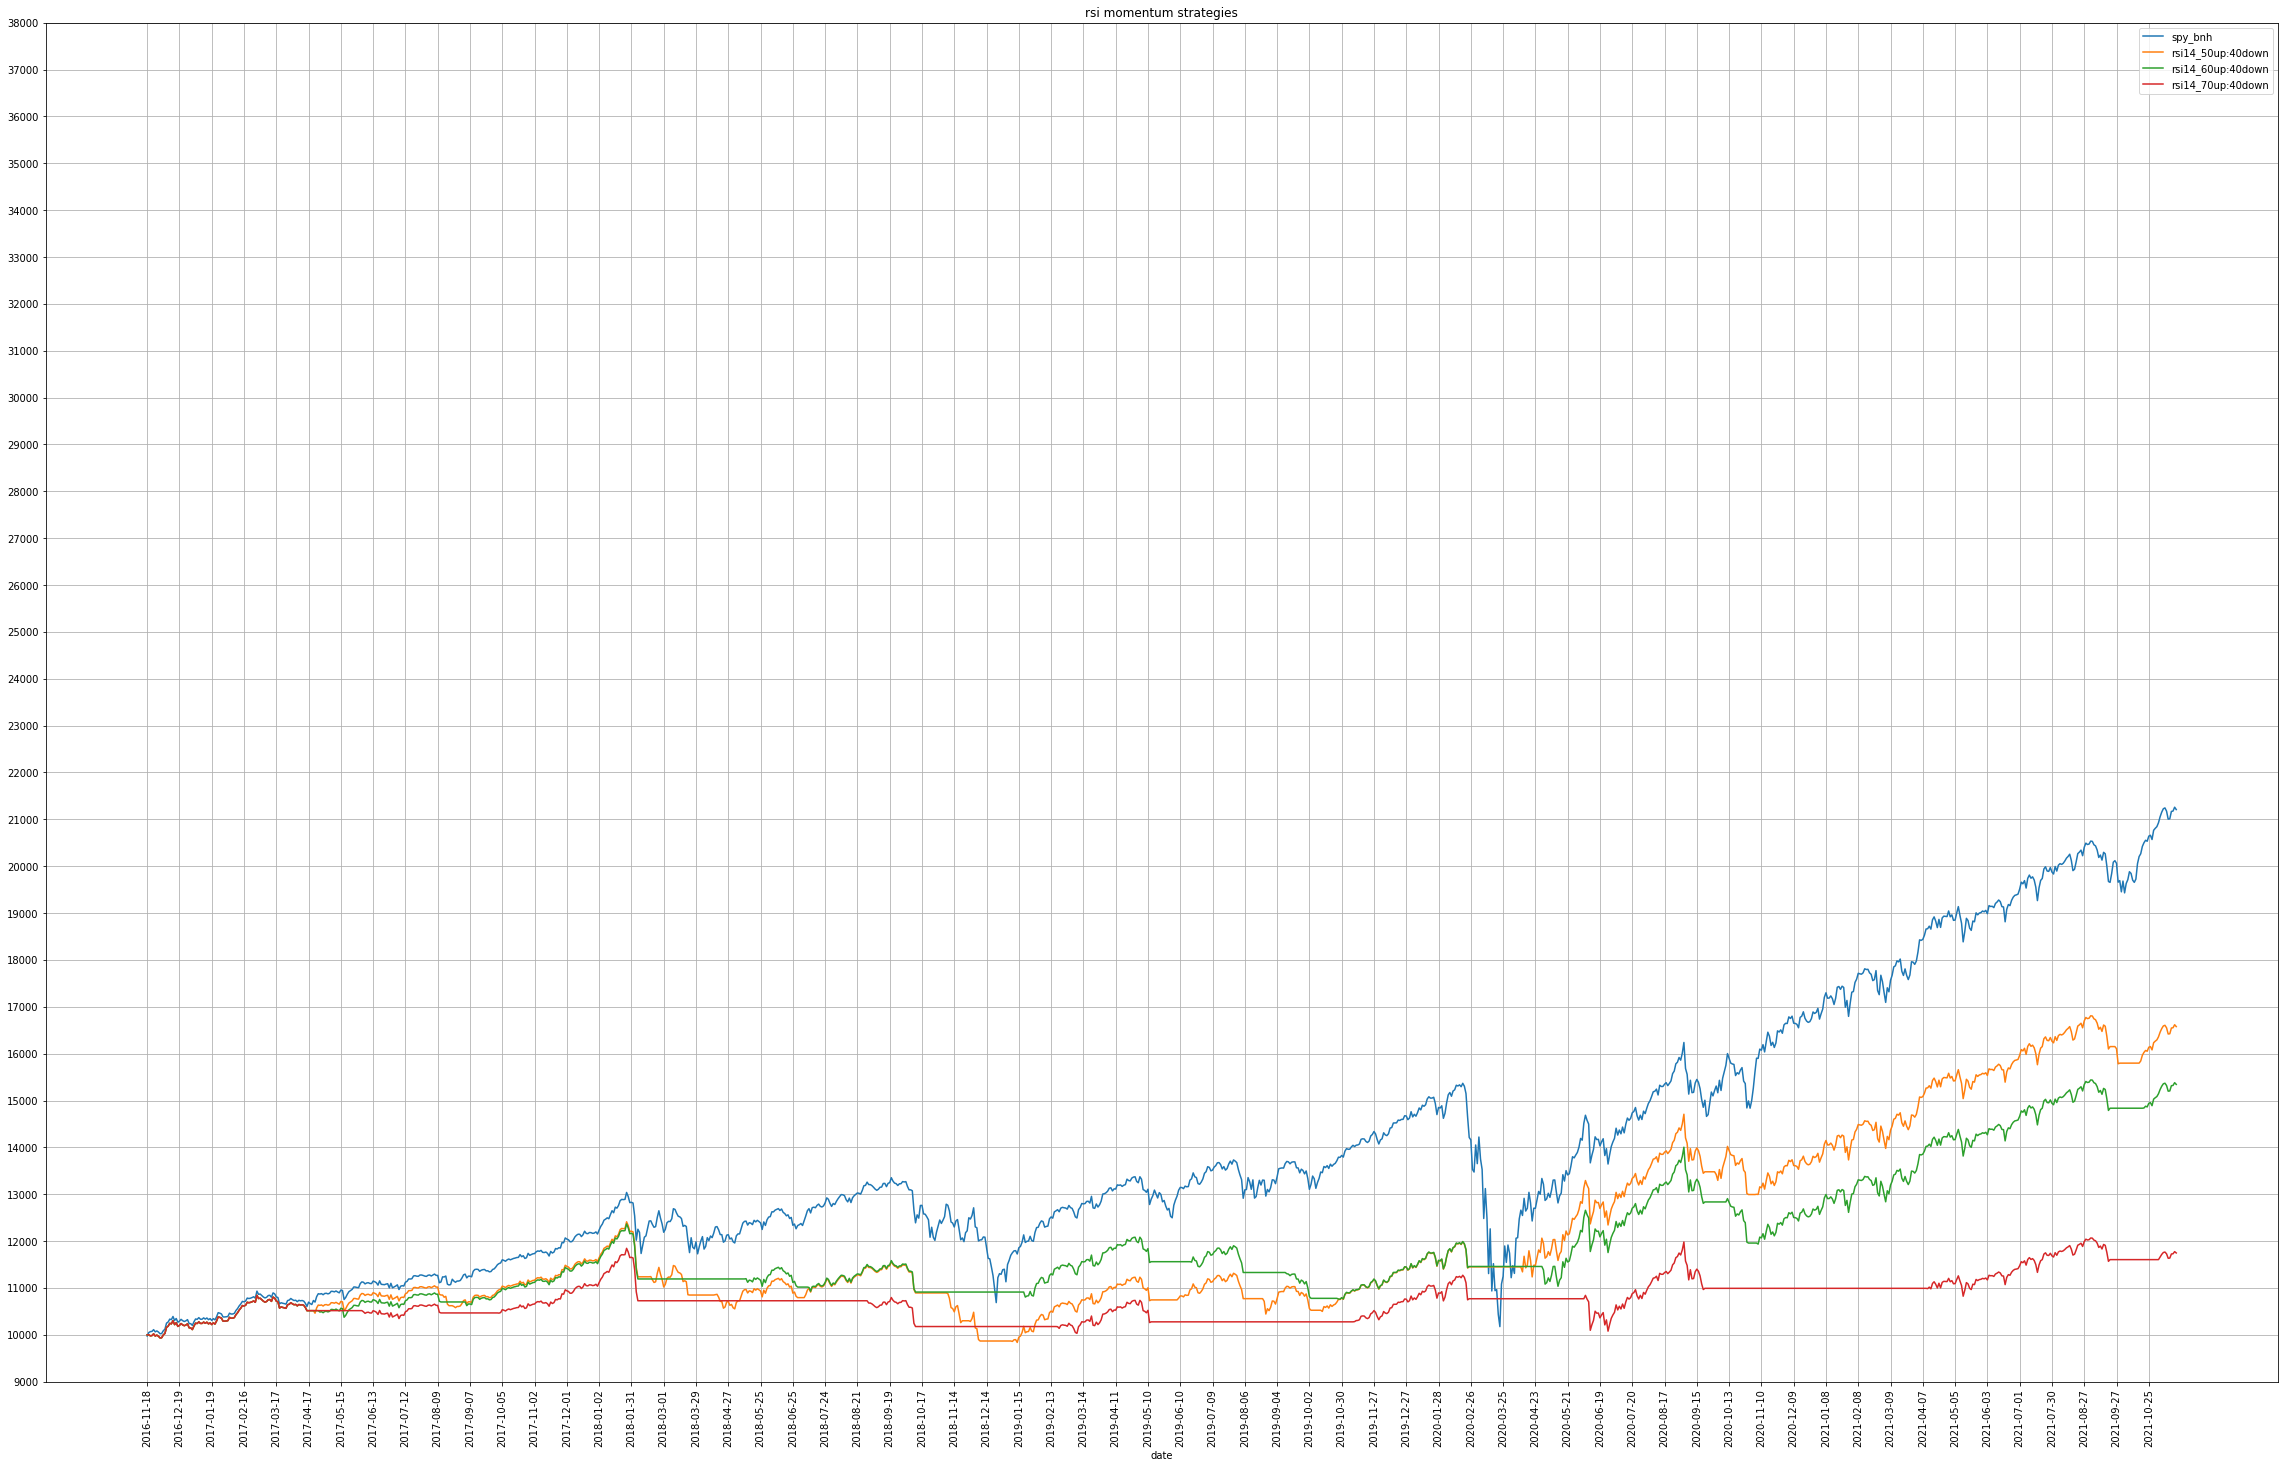

In [512]:
chart(performance_df, 9000, 39000, 1000, 'rsi momentum strategies')

In [507]:
backtest_details = [
  {'window_length':14, 'entry_threshold':(30, 'down'), 'exit_threshold':(70, 'up')},
  {'window_length':14, 'entry_threshold':(40, 'down'), 'exit_threshold':(70, 'up')},
  {'window_length':14, 'entry_threshold':(50, 'down'), 'exit_threshold':(70, 'up')},
  {'window_length':14, 'entry_threshold':(60, 'down'), 'exit_threshold':(70, 'up')},
  {'window_length':14, 'entry_threshold':(30, 'down'), 'exit_threshold':(80, 'up')},
  {'window_length':14, 'entry_threshold':(40, 'down'), 'exit_threshold':(80, 'up')},
  {'window_length':14, 'entry_threshold':(50, 'down'), 'exit_threshold':(80, 'up')},
  {'window_length':14, 'entry_threshold':(60, 'down'), 'exit_threshold':(80, 'up')},
]
performance_df = get_performance_df(spy_df, 'spy', 10000, backtest_details, bnh_start=0, to_csv=False)

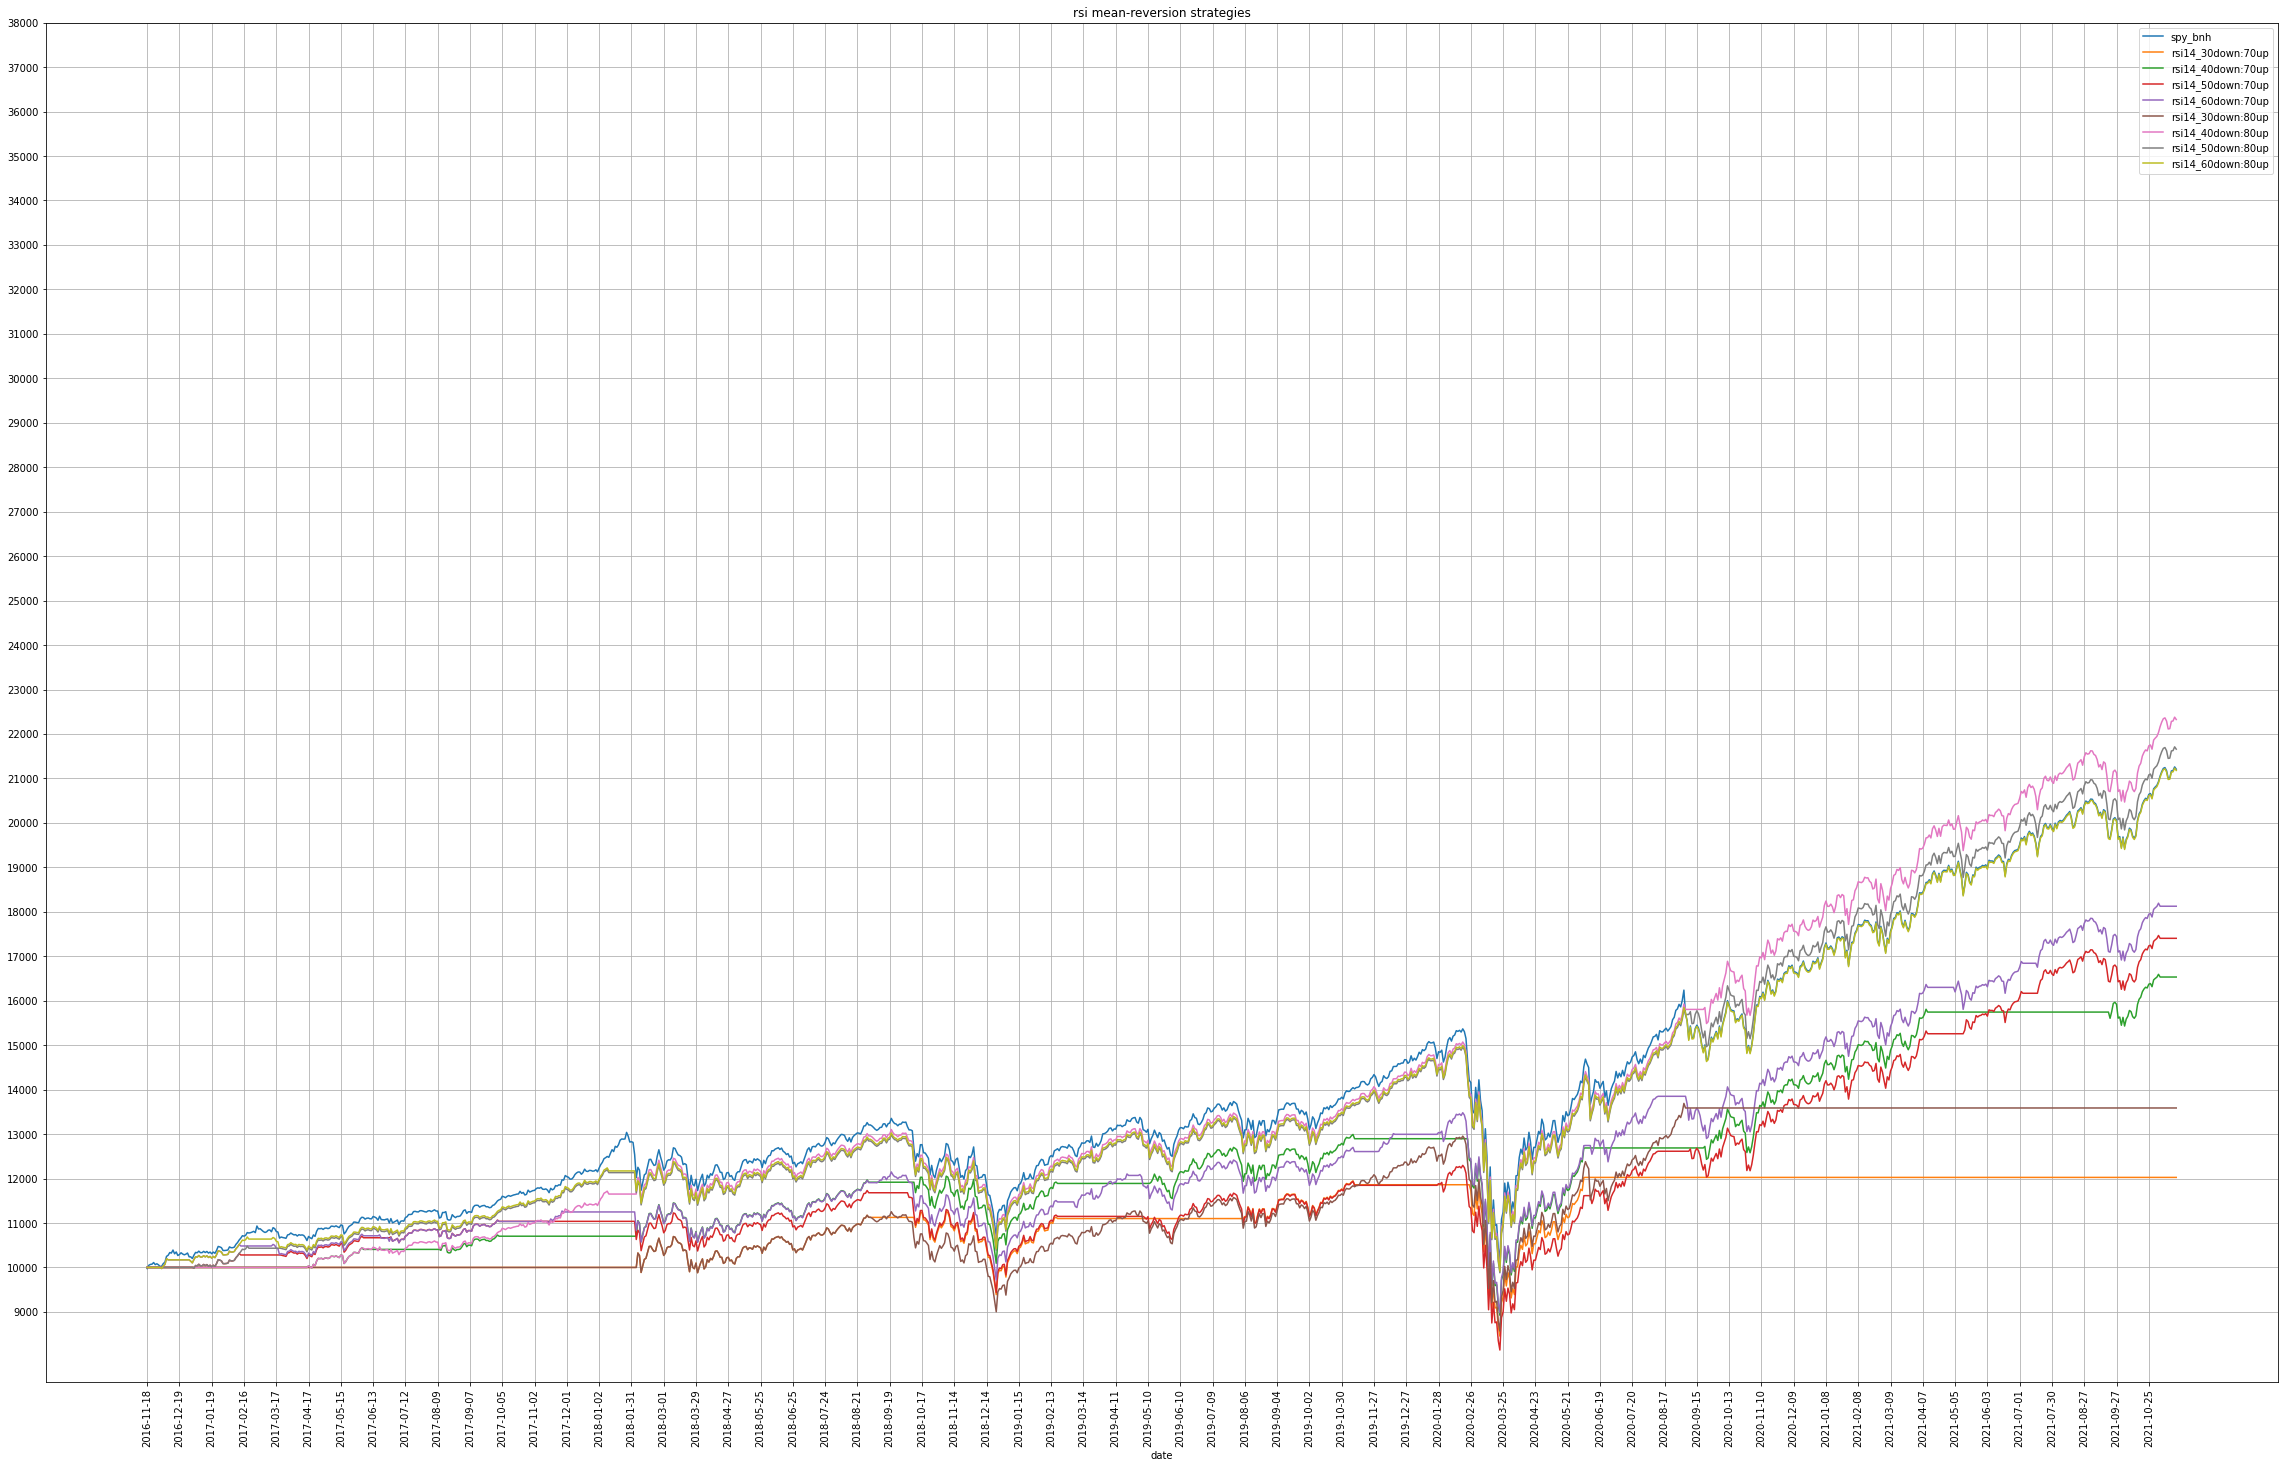

In [508]:
chart(performance_df, 9000, 39000, 1000, 'rsi mean-reversion strategies')